# SPH6004 Hands-On 3
## Tree-based models and Support Vector Machines

Contents:
* New models 
  * Tree-based models
    * Simple decision trees
    * Gradient boosting trees
  * Support vector machines (SVM)
    * linear SVM
    * SVM with the rbf kernel
* `sklearn` techniques
  * New model implementations in `sklearn`
  * Parameter selection using `GridSearchCV`
* Linearly separable and non-separable data

In [3]:
# We will use the following packages

# NumPy for math operations, and Pandas for processing tabular data.
import numpy as np
import pandas as pd

# Plotly plotting package
import plotly.graph_objects as go
import plotly.express as px

# We use toy datasets in scikit-learn package
from sklearn.datasets import load_breast_cancer

# Tools in sklearn to select best model
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

# Decision tree classifier in sklearn
from sklearn.tree import DecisionTreeClassifier as DTC, plot_tree

# We use f1 score to test model performance
from sklearn.metrics import f1_score

# Import matplotlib.pyplot to visualize tree models
import matplotlib.pyplot as plt

Again we use the breast cancer data. Recall that from last hands-on, the forward feature selection method selected `mean concave points`, `radius error` and `worst concave points` as the top-3 most important features to predict whether cell samples are benign or malignant. (Note that the forward feature selection method has build-in randomness, so if you try it multiple times you may get different top-3 features.) To ease data and model visualization we only use these tree features.

In [4]:
X_raw, y_df = load_breast_cancer(return_X_y=True, as_frame=True)

X_df = X_raw[['mean concave points', 'radius error', 'worst concave points']]
Xy = pd.concat([X_df,y_df],axis=1)
Xy['label'] = np.where(Xy['target'].to_numpy()==0,'benign','malignant')
Xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean concave points   569 non-null    float64
 1   radius error          569 non-null    float64
 2   worst concave points  569 non-null    float64
 3   target                569 non-null    int64  
 4   label                 569 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 22.4+ KB


In [33]:
fig = px.scatter_3d(
    Xy,
    z='mean concave points',
    y='radius error',
    x='worst concave points',
    color='label'
)

fig.update_traces(
    marker={'size':2.5}
)

surface_z = [[0.052,0.052],[0.052,0.052]]
surface_y = [0.1,2.7]
surface_x = [0,0.29]

fig.add_trace(
    go.Surface(
        x=surface_x,
        y=surface_y,
        z=surface_z,
        opacity=0.5,
        showscale=False,
        colorscale='greys',
        name='separating hyperplane',
        showlegend=True,
        visible='legendonly'
    )
)

fig

In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_df,y_df,test_size=0.3,random_state=10,
    stratify=y_df, shuffle=True
)

### Decision tree

In [34]:
# We first build a shallow decision tree.
TreeModel = DTC(criterion='entropy',max_depth=1,random_state=15)
TreeModel.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=15)

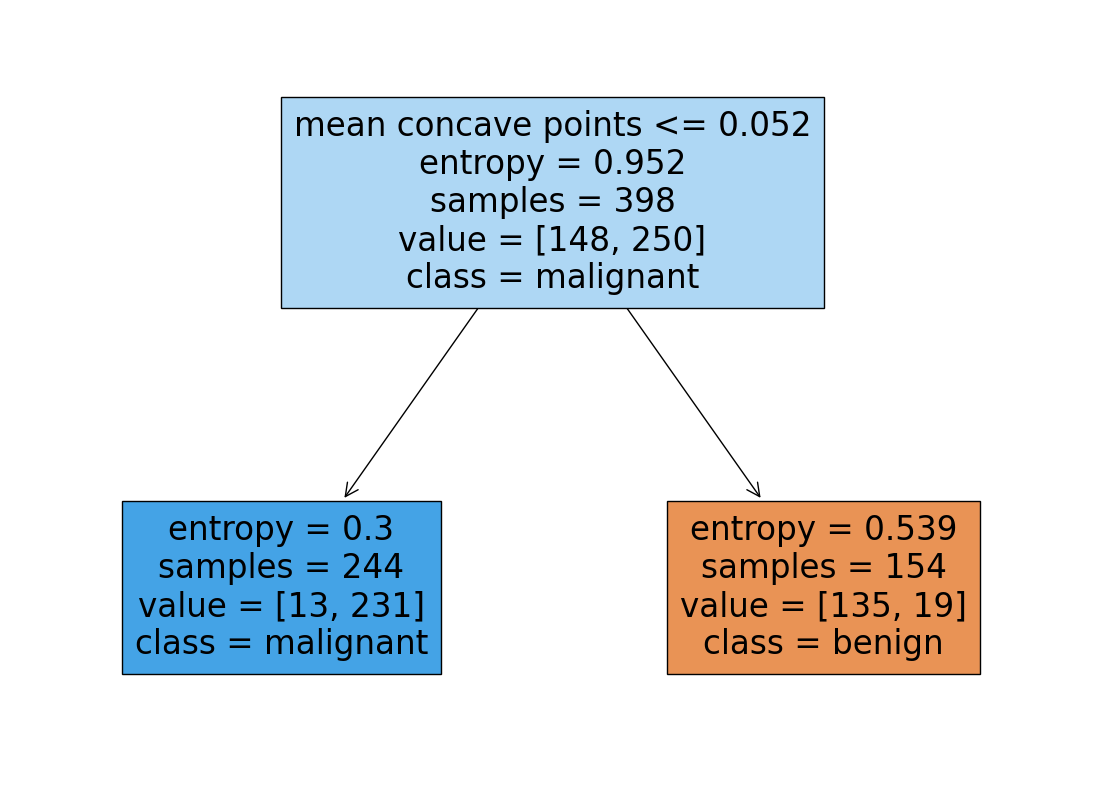

In [35]:
# Splitting rules can be visualized by using plot_tree in sklearn
plt.figure(figsize=(14,10))
plot_tree(
    TreeModel,
    filled=True,
    feature_names=['mean concave points', 'radius error', 'worst concave points'],
    class_names=['benign','malignant']
)
plt.show()

In [36]:
# The `max_depth` parameter is important for decision tree.
# We use `GridSearchCV` to select the best `max_depth`.

parameters = {'max_depth':np.arange(start=1,stop=10,step=1)}
stratifiedCV = StratifiedKFold(n_splits=8)
TreeModel = DTC(criterion='entropy')
BestTree = GridSearchCV(
    TreeModel,
    param_grid=parameters,
    scoring='f1',
    cv=stratifiedCV
)
BestTree.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='f1')

In [37]:
BestTree.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [38]:
BestTree.best_score_

0.9378725131220504

In [39]:
y_pred = BestTree.predict(X_test)
print('F1 score on test set: {:.4f}'.format(f1_score(y_test,y_pred)))
pd.crosstab(y_test,y_pred)

F1 score on test set: 0.9273


col_0,0,1
target,,
0,53,11
1,5,102


### XGBoost

In [41]:
from xgboost import XGBClassifier as XGBC

The `xgboost` is a powerful and popular gradient boosting tree model. However, it requires careful tuning of parameters. Some of important parameters:
* `n_estimators`: number of gradient boosted trees
* `max_depth`: maximum tree depth for each gradient boosted trees
* `learning_rate`: the $\eta$ in lecture notes

In [42]:
parameters = {
    'n_estimators':np.arange(start=2,stop=20,step=2),
    'max_depth':np.arange(start=2,stop=6,step=1),
    'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)
}
stratifiedCV = StratifiedKFold(n_splits=8)
# XGBC: XGBoost classifier
XGBoostModel = XGBC()
BestXGBoost = GridSearchCV(
    XGBoostModel,
    param_grid=parameters,
    scoring='f1',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1 # use all cpu cores to speedup grid search
)
BestXGBoost.fit(X_train,y_train)

Fitting 8 folds for each of 252 candidates, totalling 2016 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
                         'max_depth': array([2, 3, 4, 5]),
                         'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
             scoring='f1', verbose=1)

In [43]:
BestXGBoost.best_params_

{'learning_rate': 0.25, 'max_depth': 2, 'n_estimators': 4}

In [44]:
BestXGBoost.best_score_

0.9517362378861897

In [340]:
y_pred = BestXGBoost.predict(X_test)
print('F1 score on test set: {:.4f}'.format(f1_score(y_test,y_pred)))
pd.crosstab(y_test,y_pred)

F1 score on test set: 0.9321


col_0,0,1
target,,
0,53,11
1,4,103


### Linear SVM

Since our data seems to be linearly separable, we expect an SVM with the simple linear kernel can give us good results.

In [45]:
# Support Vector Classifier
from sklearn.svm import SVC

In [46]:
# 'C': strength of L2 regularization on linear SVM. Larger 'C' --> smaller regularization.
parameters = {
    'C':np.arange(start=1,stop=20,step=5)
}
stratifiedCV = StratifiedKFold(n_splits=8)
SVCModel = SVC(kernel='linear')
BestSVC = GridSearchCV(
    SVCModel,
    param_grid=parameters,
    scoring='f1',
    cv=stratifiedCV,
    verbose=1,
    n_jobs=-1
)
BestSVC.fit(X_train,y_train)

Fitting 8 folds for each of 4 candidates, totalling 32 fits


GridSearchCV(cv=StratifiedKFold(n_splits=8, random_state=None, shuffle=False),
             estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': array([ 1,  6, 11, 16])}, scoring='f1',
             verbose=1)

In [47]:
BestSVC.best_estimator_

SVC(C=11, kernel='linear')

In [48]:
BestSVC.best_score_

0.9491590935792455

In [49]:
y_pred = BestSVC.predict(X_test)
print('F1 score on test set: {:.4f}'.format(f1_score(y_test,y_pred)))
pd.crosstab(y_test,y_pred)

F1 score on test set: 0.9244


col_0,0,1
target,,
0,50,14
1,3,104


## An example of linearly non-separable data

In [51]:
# Generate data
r1,r2 = 0.1,2
noise_level = .5
sample_num = 1000
theta = np.linspace(0,2*np.pi,num=sample_num)

c1_x = r1*np.cos(theta)+np.random.normal(scale=noise_level,size=sample_num)
c1_y = r1*np.sin(theta)+np.random.normal(scale=noise_level,size=sample_num)

c2_x = r2*np.cos(theta)+np.random.normal(scale=noise_level,size=sample_num)
c2_y = r2*np.sin(theta)+np.random.normal(scale=noise_level,size=sample_num)

X = pd.DataFrame(
    {
        'x1':np.hstack([c1_x,c2_x]),
        'x2':np.hstack([c1_y,c2_y])
    }
)
y = pd.Series(
    data=[0]*sample_num+[1]*sample_num,
    name='label'
)

X_train,X_test,y_train,y_test = train_test_split(
    X,y,random_state=9,shuffle=True,test_size=0.3
)

Xy_test = pd.concat([X_test,y_test],axis=1)
Xy_test['label'] = Xy_test['label'].astype(str)

In [52]:
fig = px.scatter(
    Xy_test,
    x='x1',
    y='x2',
    color='label'
)

fig.update_yaxes(
    scaleanchor='x',
    scaleratio=1
)

### The failure of linear models

The above data is clearly not linearly separable, i.e. you cannot use a line to separate the two classes. Linear models we learned in this course, e.g. logistic regression and SVM with linear kernel, cannot handle such data.

In [53]:
from sklearn.linear_model import LogisticRegression as LR

linear_models = {
    'LR':LR(),
    'SVM_linear':SVC(kernel='linear')
}

stratifiedCV = StratifiedKFold(n_splits=8)


params = {
    'LR':{
        'C':np.arange(0.5,20,step=1)
    },
    'SVM_linear':{
        'C':np.arange(0.5,20,step=1)
    }
}

records = {}

for model in linear_models:
    BestParams = GridSearchCV(
        linear_models[model],
        param_grid = params[model],
        scoring='f1',
        cv=stratifiedCV,
        n_jobs=-1 # Use all cpu cores to speed-up CV search
    )
    BestParams.fit(X_train,y_train)
    records[model] = BestParams
    Xy_test[model] = BestParams.predict(X_test).astype(str)
    print('For {} cross validation F1 score is {:.4f}'.format(model,BestParams.best_score_))

For LR cross validation F1 score is 0.5076
For SVM_linear cross validation F1 score is 0.4953


In [54]:
fig = px.scatter(
    Xy_test.melt(id_vars=['x1','x2'],value_vars=['label','LR','SVM_linear']),
    x='x1',
    y='x2',
    facet_col='variable',
    color='value'
)
fig.update_yaxes(
    scaleanchor='x',
    scaleratio=1
)

We can see that both linear methods can only try to separate the two classes by a line. Since data cannot be separated by a line, the prediction accuracy is poor.

### Nonlinear methods

Let us try to classify the two classes by non-linear methods, which include
* Decision tree and its related models
* SVM to rbf kernel

In [55]:
nonlinear_models = {
    'DecisionTree':DTC(criterion='entropy'),
    'XGBoost':XGBC(),
    'SVM_rbf':SVC(kernel='rbf')
}

stratifiedCV = StratifiedKFold(n_splits=8)


params = {
    'DecisionTree':{
        'max_depth':np.arange(start=1,stop=10)
    },
    'XGBoost':{
        'n_estimators':np.arange(start=2,stop=20,step=2),
        'max_depth':np.arange(start=2,stop=6),
        'learning_rate':np.arange(start=0.05,stop=0.4,step=0.05)
    },
    'SVM_rbf':{
        'C':np.arange(0.5,5,step=0.5)
    }
}

records = {}

for model in nonlinear_models:
    BestParams = GridSearchCV(
        nonlinear_models[model],
        param_grid = params[model],
        scoring='f1',
        cv=stratifiedCV,
        n_jobs=-1
    )
    BestParams.fit(X_train,y_train)
    Xy_test[model] = BestParams.predict(X_test).astype(str)
    records[model] = BestParams
    print('For {} cross validation F1 score is {:.4f}'.format(model,BestParams.best_score_))

For DecisionTree cross validation F1 score is 0.9390
For XGBoost cross validation F1 score is 0.9493
For SVM_rbf cross validation F1 score is 0.9493


In [56]:
fig = px.scatter(
    Xy_test.melt(id_vars=['x1','x2'],value_vars=['label','DecisionTree','XGBoost','SVM_rbf']),
    x='x1',
    y='x2',
    facet_col='variable',
    color='value'
)
fig.update_traces(
    marker={'size':5}
)
fig.update_yaxes(
    scaleanchor='x',
    scaleratio=1
)